In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

qiskit_runtime_service.__init__:INFO:2023-12-22 11:17:00,449: Default instance: ibm-q/open/main


In [2]:
import qiskit.tools.jupyter

%qiskit_version_table

In [3]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import pylab

import networkx as nx

from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA, COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler 
from qiskit_optimization.algorithms import MinimumEigenOptimizer

from qiskit_optimization.converters import QuadraticProgramToQubo

from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector

from itertools import permutations #per brutal approches TSP

In [4]:
#draw a graph coloring the nodes 

#funzione per disegnare un grafo con nodi colorati
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    
#funzione per disegnare un cammino su un grafo 
def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)

### TSP 

distance
 [[0. 1. 1.]
 [1. 0. 3.]
 [1. 3. 0.]]


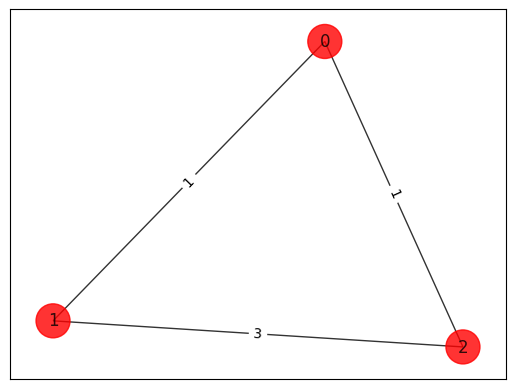

In [5]:
# Generating a random graph 
#n = 3 # num
#num_qubits = n**2
#tsp = Tsp.create_random_instance(n) 
#G=tsp.graph


# Creating a specific graph

n=3 #numero di nodi 
G= nx.Graph() # definizione del grafo
G.add_nodes_from(np.arange(0, n, 1)) # aggiungo i vertici 
elist = [(0, 1, 1), (0, 2, 1), (1, 2, 3)] # definisco la lista degli archi [(i,j,peso)]
## tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)# aggiungo gli archi al grafo

tsp=Tsp(G)

# grafico
adj_matrix = nx.to_numpy_array(G)
print("distance\n", adj_matrix)
colors = ["r" for node in G.nodes]
pos = nx.spring_layout(G)
draw_graph(tsp.graph, colors, pos)


In [6]:
## define the ising model

qp = tsp.to_quadratic_program()
qp2qubo= QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()

In [7]:
###EXACT SOLUTION
###Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
#ee = NumPyMinimumEigensolver()
#result = ee.compute_minimum_eigenvalue(qubitOp)

#print("energy:", result.eigenvalue.real)
#print("tsp objective:", result.eigenvalue.real + offset)
#x = tsp.sample_most_likely(result.eigenstate)
#print("feasible:", qubo.is_feasible(x))
#z= tsp.interpret(x)
#print("solution:", z)
#print("solution objective:", tsp.tsp_value(z, adj_matrix))

In [9]:
# create the ANSATZ

###standard ansatz
#ansatz= TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=2, entanglement="linear") 

###specific ansatz
theta = ParameterVector('theta', qubitOp.num_qubits)
ansatz = QuantumCircuit(qubitOp.num_qubits)
for i in range (0,qubitOp.num_qubits, tsp.graph.number_of_nodes()):
    ansatz.x(i)
    for j in range(i+1,i+tsp.graph.number_of_nodes(),1):
        ansatz.ry(theta[j-1], j)
        ansatz.cz(j-1,j)
        ansatz.ry(-theta[j-1], j)
    for j in range(i+1,i+tsp.graph.number_of_nodes(),1):
        ansatz.cx(j,j-1)

In [38]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler #solo per eseguire il cicuito in runtime

In [12]:
optimizer = COBYLA(maxiter=50, tol=0.5) #define the optimizer

vqe= SamplingVQE(sampler=Sampler(backend="ibm_brisbane"), ansatz=ansatz, optimizer=optimizer) #define the SamplingVqe
# run SamplingVQE 
while True:
    result=vqe.compute_minimum_eigenvalue(qubitOp)
    if qp.is_feasible(tsp.sample_most_likely(result.eigenstate)) == True:
        break


energy: -174.33623191646495
time: 0.6551878452301025
feasible: True
solution: [2, 1, 0]
solution objective: 5.0


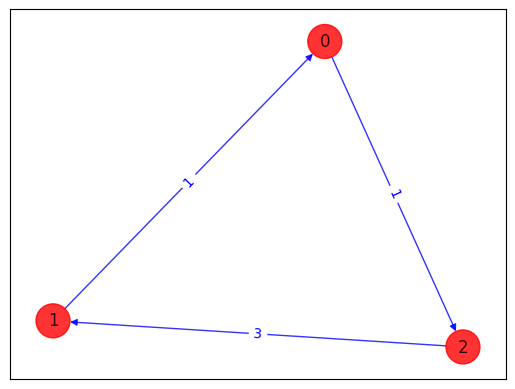

In [13]:
#result

print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x= tsp.sample_most_likely(result.eigenstate)
print("feasible:", qp.is_feasible(x))
z = tsp.interpret(x) #cammino 
print("solution:", z)
p=tsp.tsp_value(z, adj_matrix) # peso totale del cammino
print("solution objective:", p) 
draw_tsp_solution(tsp.graph, z, colors, pos) #plot della soluzioe